## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

In [ ]:
features = df_encoded.select_dtypes(["float64", "int64", "boolean"]).columns
x = df_encoded[features].drop("views", axis=1)
y = df_encoded.views
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Create a train and test dataset
data_train = pd.concat([xtrain, ytrain], axis=1)
data_test  = pd.concat([xtest, ytest], axis=1)

# Standardize the data
scaler    = RobustScaler()
scaler.fit(data_train)
std_train = scaler.transform(data_train)
std_test  = scaler.transform(data_test)

# Turn into data frame
std_train = pd.DataFrame(std_train, columns=data_train.columns)
std_test  = pd.DataFrame(std_test, columns=data_test.columns)

# Re-split the data
xtrain_std = std_train.drop("views", axis=1)
ytrain_std = std_train.views
xtest_std  = std_test.drop("views", axis=1)
ytest_std  = std_test.views  

In [ ]:
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Inisialisasi model
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Konversi khusus untuk XGBoost (harus float32)
xtrain_std_np = xtrain_std.to_numpy().astype("float32")
xtest_std_np  = xtest_std.to_numpy().astype("float32")

# Loop evaluasi
for name, model in models.items():
    if name == "XGBoost":
        X_train, X_test = xtrain_std_np, xtest_std_np
    else:
        X_train, X_test = xtrain_std, xtest_std

    model.fit(X_train, ytrain_std)

    # Prediksi train dan test
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Evaluasi train
    r2_train  = r2_score(ytrain_std, y_train_pred)
    mae_train = mean_absolute_error(ytrain_std, y_train_pred)
    mse_train = mean_squared_error(ytrain_std, y_train_pred)
    rmse_train = np.sqrt(mse_train)

    # Evaluasi test
    r2_test  = r2_score(ytest_std, y_test_pred)
    mae_test = mean_absolute_error(ytest_std, y_test_pred)
    mse_test = mean_squared_error(ytest_std, y_test_pred)
    rmse_test = np.sqrt(mse_test)

    # Print hasil
    print(f"\n📌 Model: {name}")
    print("📊 Training Metrics:")
    print(f" - R²     : {r2_train:.4f}")
    print(f" - MAE    : {mae_train:.4f}")
    print(f" - RMSE   : {rmse_train:.4f}")
    print("📊 Testing Metrics:")
    print(f" - R²     : {r2_test:.4f}")
    print(f" - MAE    : {mae_test:.4f}")
    print(f" - RMSE   : {rmse_test:.4f}")

    # Analisis
    if r2_train - r2_test > 0.15:
        print("⚠️  Overfitting terdeteksi.")
    elif r2_train < 0.6 and r2_test < 0.6:
        print("⚠️  Underfitting kemungkinan terjadi.")
    else:
        print("✅  Model generalisasi dengan baik.")


📌 Model: LinearRegression
📊 Training Metrics:
 - R²     : 0.2871
 - MAE    : 0.5859
 - RMSE   : 0.8222
📊 Testing Metrics:
 - R²     : 0.2788
 - MAE    : 0.5942
 - RMSE   : 0.8349
⚠️  Underfitting kemungkinan terjadi.

📌 Model: RandomForest
📊 Training Metrics:
 - R²     : 0.9385
 - MAE    : 0.1552
 - RMSE   : 0.2416
📊 Testing Metrics:
 - R²     : 0.5680
 - MAE    : 0.4140
 - RMSE   : 0.6462
⚠️  Overfitting terdeteksi.

📌 Model: XGBoost
📊 Training Metrics:
 - R²     : 0.7162
 - MAE    : 0.3481
 - RMSE   : 0.5188
📊 Testing Metrics:
 - R²     : 0.5259
 - MAE    : 0.4450
 - RMSE   : 0.6769
⚠️  Overfitting terdeteksi.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def plot_actual_vs_pred(y_true, y_pred, model_name):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.5, color='cornflowerblue', label='Predicted')
    
    # Garis referensi
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')

    # Tambahkan metrik ke dalam grafik
    textstr = f"R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}"
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Actual Views")
    plt.ylabel("Predicted Views")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.5, color='salmon')
    plt.axhline(0, color='black', linestyle='--')

    plt.title(f"{model_name} - Residual Plot")
    plt.xlabel("Predicted Views")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


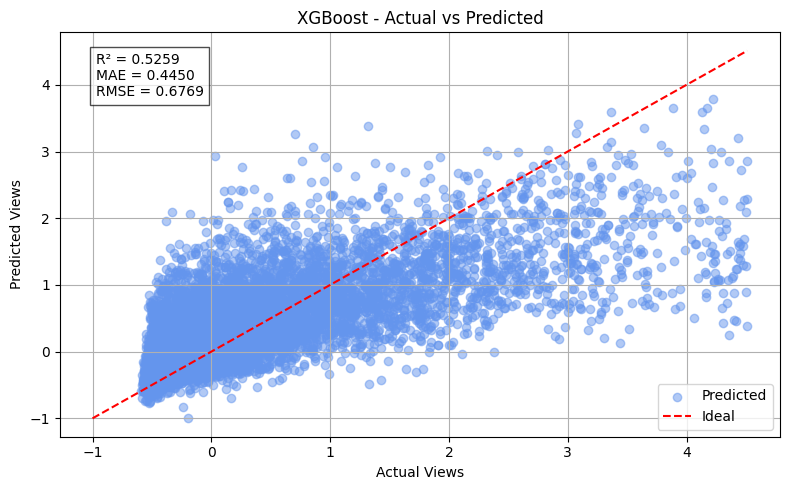

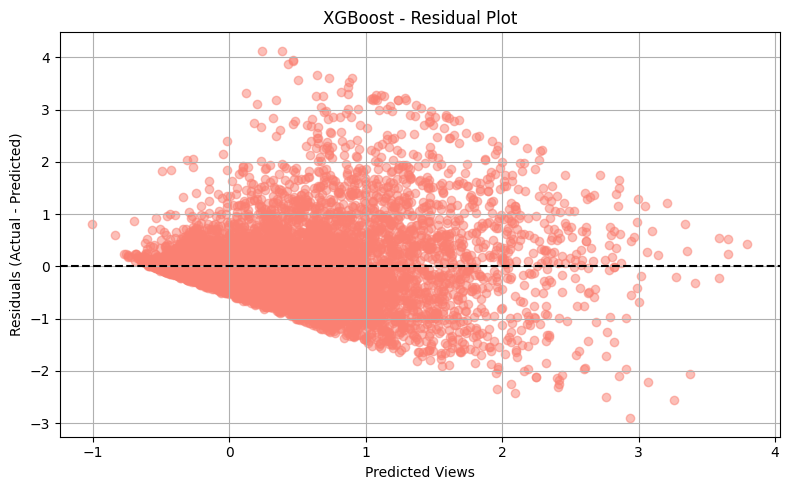

In [ ]:
y_pred_xgb = models["XGBoost"].predict(xtest_std_np)

plot_actual_vs_pred(ytest_std, y_pred_xgb, "XGBoost")
plot_residuals(ytest_std, y_pred_xgb, "XGBoost")

c:\Users\666\miniconda3\envs\latihan_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


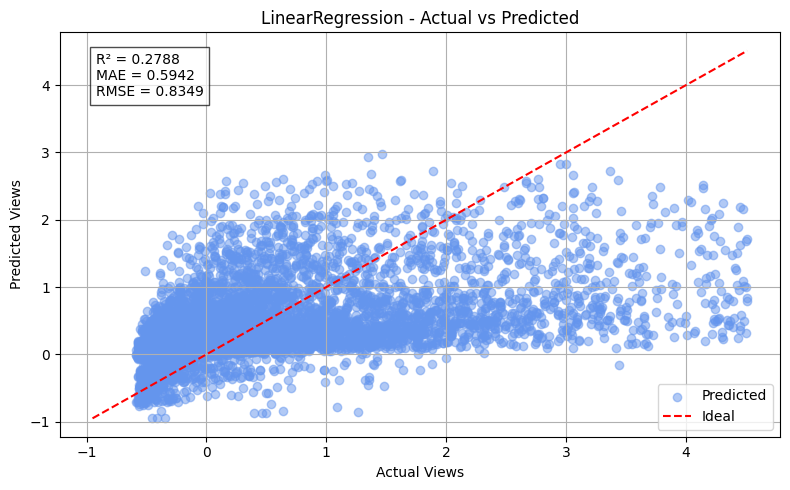

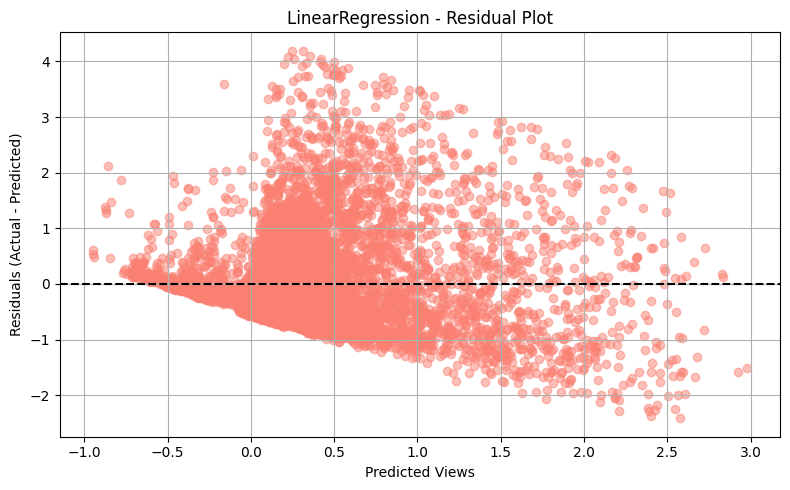

In [ ]:
y_pred_xgb = models["LinearRegression"].predict(xtest_std_np)

plot_actual_vs_pred(ytest_std, y_pred_xgb, "LinearRegression")
plot_residuals(ytest_std, y_pred_xgb, "LinearRegression")

c:\Users\666\miniconda3\envs\latihan_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


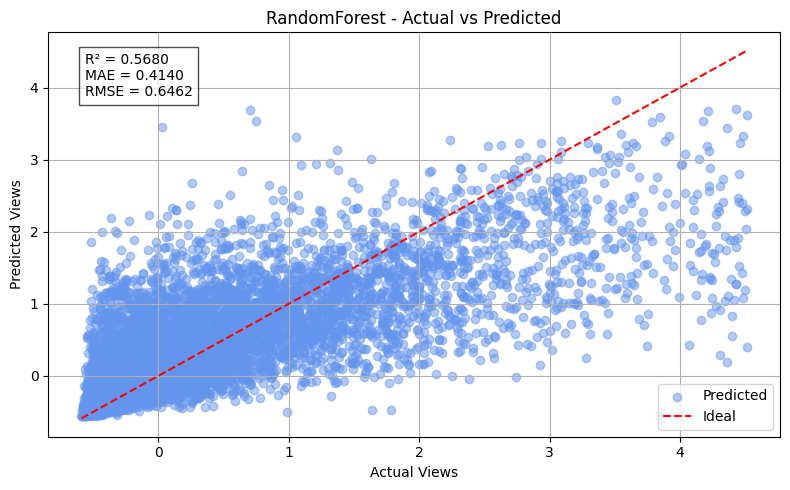

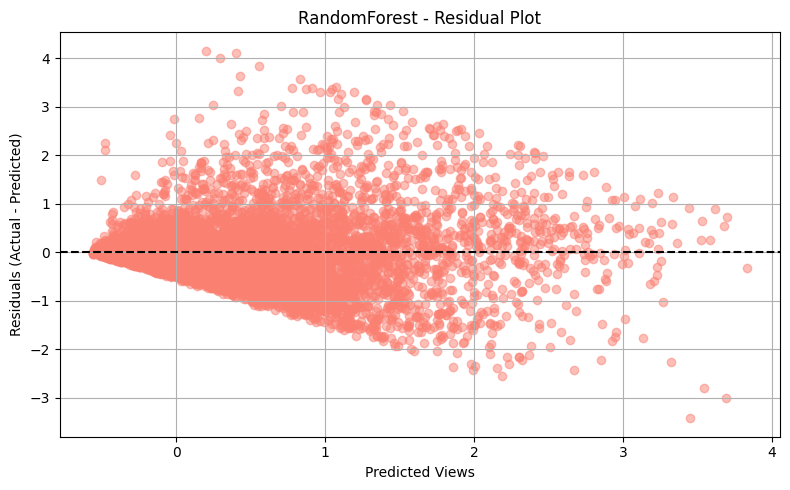

In [ ]:
y_pred_xgb = models["RandomForest"].predict(xtest_std_np)

plot_actual_vs_pred(ytest_std, y_pred_xgb, "RandomForest")
plot_residuals(ytest_std, y_pred_xgb, "RandomForest")

In [ ]:
# ======================================
#  REGRESSION MODELS: TRAIN - TUNING
# ======================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ======================
# 1. PREPARE DATA
# ======================

# Load data (pastikan sudah preprocessed sebelumnya)
df = df_encoded.copy()  # Gunakan dataframe hasil encoding dan pembersihan

features = df.select_dtypes(["float64", "int64", "boolean"]).columns
x = df[features].drop("views", axis=1)
y = df.views

# Split data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Standardize
scaler = RobustScaler()
scaler.fit(xtrain)
xtrain_std = scaler.transform(xtrain)
xtest_std = scaler.transform(xtest)

# ======================
# 2. DEFINE EVALUATION
# ======================

def eval_model(name, model, xtrain, ytrain, xtest, ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    print(f"\n\U0001F4C8 Model: {name}")
    print("\U0001F4CA Training Metrics:")
    print(" - R^2     :", round(r2_score(ytrain, ytrain_pred), 4))
    print(" - MAE     :", round(mean_absolute_error(ytrain, ytrain_pred), 4))
    print(" - RMSE    :", round(np.sqrt(mean_squared_error(ytrain, ytrain_pred)), 4))

    print("\U0001F4CA Testing Metrics:")
    print(" - R^2     :", round(r2_score(ytest, ytest_pred), 4))
    print(" - MAE     :", round(mean_absolute_error(ytest, ytest_pred), 4))
    print(" - RMSE    :", round(np.sqrt(mean_squared_error(ytest, ytest_pred)), 4))

# ======================
# 3. TRAIN BASE MODELS
# ======================

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "LGBMRegressor": LGBMRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(xtrain_std, ytrain)
    eval_model(name, model, xtrain_std, ytrain, xtest_std, ytest)

# ======================
# 4. TUNING TOP 3 MODELS
# ======================

# -- Random Forest Tuning
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_grid, scoring='r2', cv=5)
rf.fit(xtrain_std, ytrain)
eval_model("RandomForest (Tuned)", rf.best_estimator_, xtrain_std, ytrain, xtest_std, ytest)

# -- HistGradientBoosting Tuning
hgb_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 10]
}
hgb = GridSearchCV(HistGradientBoostingRegressor(random_state=42), hgb_grid, scoring='r2', cv=5)
hgb.fit(xtrain_std, ytrain)
eval_model("HistGradientBoosting (Tuned)", hgb.best_estimator_, xtrain_std, ytrain, xtest_std, ytest)

# -- LightGBM Tuning
lgbm_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10]
}
lgbm = GridSearchCV(LGBMRegressor(random_state=42), lgbm_grid, scoring='r2', cv=5)
lgbm.fit(xtrain_std, ytrain)
eval_model("LGBMRegressor (Tuned)", lgbm.best_estimator_, xtrain_std, ytrain, xtest_std, ytest)


In [ ]:
# ======================
# 1. PREPARE DATA (Best Practice)
# ======================

# Load data (pastikan sudah preprocessed sebelumnya)
df = df_encoded.copy()  # Gunakan dataframe hasil encoding dan pembersihan

# Pilih fitur numerik dan boolean
features = df.select_dtypes(["float64", "int64", "boolean"]).columns
x = df[features].drop("views", axis=1)
y = df.views

# Split data menjadi train/test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=1/3, random_state=42)

# Standarisasi hanya fitur X (bukan target y)
scaler = RobustScaler()
scaler.fit(xtrain)
xtrain_std = scaler.transform(xtrain)
xtest_std = scaler.transform(xtest)

# ======================
# 2. DEFINE EVALUATION
# ======================

def eval_model(name, model, xtrain, ytrain, xtest, ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    r2_train = r2_score(ytrain, ytrain_pred)
    r2_test = r2_score(ytest, ytest_pred)

    print(f"\n\U0001F4C8 Model: {name}")
    print("\U0001F4CA Training Metrics:")
    print(" - R^2     :", round(r2_train, 4))
    print(" - MAE     :", round(mean_absolute_error(ytrain, ytrain_pred), 4))
    print(" - RMSE    :", round(np.sqrt(mean_squared_error(ytrain, ytrain_pred)), 4))

    print("\U0001F4CA Testing Metrics:")
    print(" - R^2     :", round(r2_test, 4))
    print(" - MAE     :", round(mean_absolute_error(ytest, ytest_pred), 4))
    print(" - RMSE    :", round(np.sqrt(mean_squared_error(ytest, ytest_pred)), 4))

    # ======================
    # 3. DETEKSI OVERFITTING / UNDERFITTING
    # ======================
    print("\n\U0001F6A7 Model Diagnosis:")
    if r2_train - r2_test > 0.15:
        print("⚠️  Overfitting terdeteksi → Model terlalu bagus di training, tapi buruk di testing.")
    elif r2_train < 0.6 and r2_test < 0.6:
        print("⚠️  Underfitting kemungkinan terjadi → Model gagal mempelajari pola baik dari data.")
    else:
        print("✅  Model generalisasi dengan baik.")

# ======================
# 3. TRAIN BASE MODELS
# ======================

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "LGBMRegressor": LGBMRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(xtrain_std, ytrain)
    eval_model(name, model, xtrain_std, ytrain, xtest_std, ytest)

# ======================
# 4. VISUALISASI REGRESI & RESIDUAL
# ======================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_diagnostics(name, model, xtest, ytest):
    y_pred = model.predict(xtest)
    residuals = ytest - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"🔍 Diagnostik Model: {name}", fontsize=14)

    # Scatter plot: Predicted vs Actual
    sns.scatterplot(x=ytest, y=y_pred, ax=axes[0])
    axes[0].set_xlabel("Aktual")
    axes[0].set_ylabel("Prediksi")
    axes[0].set_title("📈 Prediksi vs Aktual")
    axes[0].plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red', linestyle='--')

    # Residual plot
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_xlabel("Prediksi")
    axes[1].set_ylabel("Residual (Aktual - Prediksi)")
    axes[1].set_title("📉 Residual Plot")

    plt.tight_layout()
    plt.show()

# Jalankan visualisasi untuk setiap model
for name, model in models.items():
    plot_diagnostics(name, model, xtest_std, ytest)
